# Introduction

In this notebook, I will try and use different techniques I have learned from the **Deep Learning with PyTorch: Zero to GANs** course.

I have chosen the `Intel Image Classification` dataset as part of a previous competition:

> https://www.kaggle.com/puneet6060/intel-image-classification

**Context:** The data contains images of different natural scenes around the world.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

**Problem:** Multi Class Image Classification

The notebook is divided into different sections:
* Import Libraries
* Data Loading, Exploration and Manipulation
* Defining the Model
* Training the Model
* Model Verification
* Summary

# Import Libraries


In [3]:
!pip install jovian --upgrade --quiet

In [4]:
#Import Libraries
import os
import torch
import torchvision
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [5]:
#project name
project_name='landscape-classification-zerotogans-project'

In [7]:
#Install opendatasets library for downloading data from kaggle
#opendatasets is developed by jovianML team https://github.com/JovianML/opendatasets
!pip install opendatasets --upgrade --quiet

# Data Loading, Exploration and Manipulation

## Data Loading

In [9]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'
od.download(dataset_url)

  7%|▋         | 23.0M/346M [00:00<00:01, 239MB/s]

100%|██████████| 346M/346M [00:02<00:00, 149MB/s]


In [10]:
data_dir = "./intel-image-classification/seg_train/seg_train/"
test_data_dir = "./intel-image-classification/seg_test/seg_test"
pred_data_dir = "./intel-image-classification/seg_pred/seg_pred"

classes = os.listdir(data_dir)
print(classes)

['glacier', 'buildings', 'forest', 'street', 'mountain', 'sea']


## Normalization & Data Augmentation

* **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [11]:
# Data transforms (data augmentation), No Normalization applied yet

#test applying resize and random horizontal flip first
train_tfms = tt.Compose([
                         #tt.RandomCrop(150, padding=4, padding_mode='reflect'), 
                         tt.Resize((128,128)),
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()
                         #,
                         #tt.Normalize(*stats,inplace=True)
                         ])
valid_tfms = tt.Compose([ 
                         tt.Resize((128,128)),
                         tt.ToTensor()
                         #,
                         #tt.Normalize(*stats)
                         ])

We can create training and validation datasets using the ImageFolder class from torchvision

In [12]:
# PyTorch datasets
train_ds = ImageFolder(data_dir, train_tfms)
valid_ds = ImageFolder(test_data_dir, valid_tfms)

In [11]:
#Calculate the mean and std stats from the training data for normalization
loader = DataLoader(train_ds, batch_size=128)

nimages = 0
mean = 0.
std = 0.
for batch, _ in loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print(nimages)
print(mean)
print(std)

14034
tensor([0.4302, 0.4575, 0.4539])
tensor([0.2220, 0.2208, 0.2299])


Apply normalization

In [13]:
# Data transforms (normalization & data augmentation)
stats = ((0.4302, 0.4575, 0.4539), (0.2220, 0.2208, 0.2299))

#test applying resize and random horizontal flip first
train_tfms = tt.Compose([
                         #tt.RandomCrop(150, padding=4, padding_mode='reflect'), 
                         tt.Resize((128,128)),
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)
                         ])
valid_tfms = tt.Compose([ 
                         tt.Resize((128,128)),
                         tt.ToTensor(),
                         tt.Normalize(*stats)
                         ])

In [14]:
# PyTorch datasets
train_ds = ImageFolder(data_dir, train_tfms)
valid_ds = ImageFolder(test_data_dir, valid_tfms)

## Data Exploration

Each image is RGB with 150 x 150 pixels. To verify that we can use the shape function.

In [15]:
img, label = train_ds[179]
print(img.shape,label)
#verify the shape is set to [3, 128, 128] to signify RGB with 128 x 128 pixels

torch.Size([3, 128, 128]) 0


In [16]:
print(f"Images in training dataset : {len(train_ds)}")
print(f"Images in validation/test dataset : {len(valid_ds)}")

Images in training dataset : 14034
Images in validation/test dataset : 3000


There are 14,034 images in our training dataset and 3,000 images in our validation/test dataset.

## Load Data into Batches

Define Batch Size

**Model 1 Config:**
> Usable: batch_size=64,100

> Encountering `RuntimeError: CUDA out of memory.` when using batch_size=200,256,128

**Model 2 Config:**
> Usable: batch_size=64,128

> Encountering `RuntimeError: CUDA out of memory.` when using batch_size=200,256

In [17]:
#Batch Size (Previously used batch_size=64,128,256)
#
batch_size = 100

In [18]:
# PyTorch data loaders (Previously used num_workers=3)
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
valid_dl = DataLoader(valid_ds, 
                      batch_size*2, 
                      num_workers=4, 
                      pin_memory=True)

We'll define a function that can `denormalize` an image. 

We'll also define a `show_batch` function to show samples of the images in a 12 x 12 grid.

In [18]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

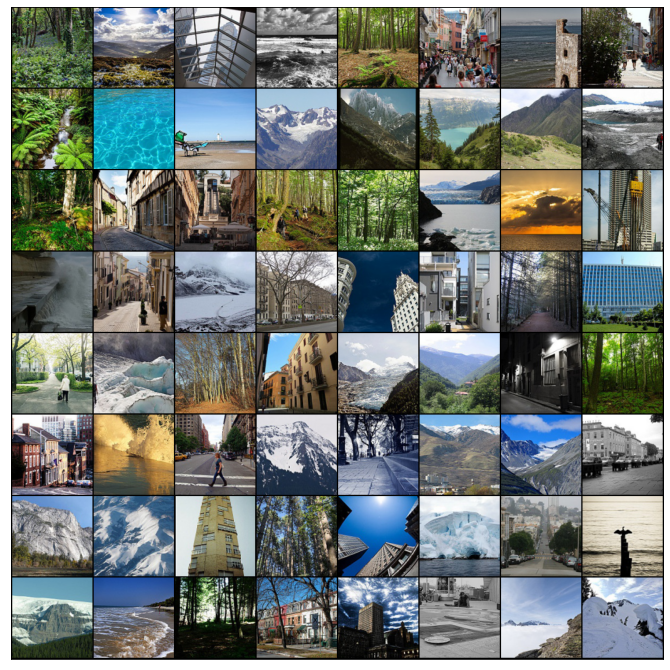

In [ ]:
show_batch(train_dl)

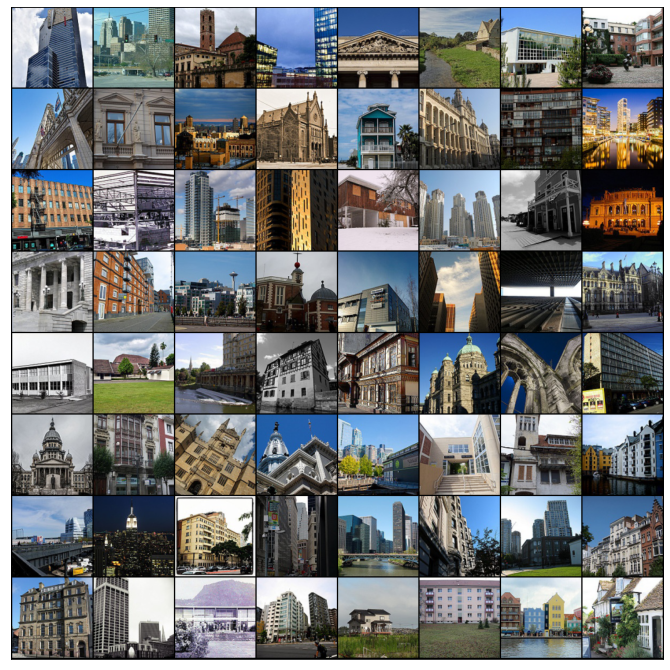

In [ ]:
show_batch(valid_dl)

We will also define a function `display_image` that will show an individual image.

In [19]:
def display_image(img,label,dataset):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : buildings


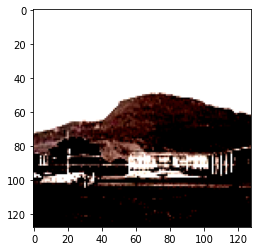

In [33]:
display_image(*train_ds[0],train_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : buildings


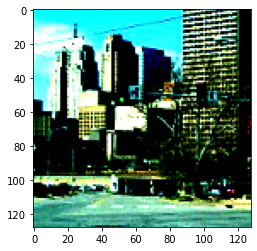

In [34]:
display_image(*valid_ds[1],valid_ds)

Notice that the photo looks different due to the normalization technique applied to all the images

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).


In [21]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Defining the Model

## Image Classification Base

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Define Different Types of Models

These section defines different models attempted in this project

### ResNet9 Model

In [23]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64) #64 x 128 x 128
        self.conv2 = conv_block(64, 128, pool=True) #128 x 64 x 64
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) #128 x 64 x 64
        
        self.conv3 = conv_block(128, 256, pool=True) #256 x 32 x 32
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 16 x 16
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #512 x 16 x 16
        
        self.classifier = nn.Sequential(nn.MaxPool2d(16),  #512 x 1 x 1
                                        nn.Flatten(),      # 512
                                        nn.Dropout(0.2),   #512
                                        nn.Linear(512, num_classes)) #6 (total number of classes)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [24]:
model = to_device(ResNet9(3, 6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [25]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([100, 3, 128, 128])
out.shape: torch.Size([100, 6])
out[0]: tensor([ 2.1457, -1.6344,  3.9219,  2.3059, -2.4471,  3.1737], device='cuda:0',
       grad_fn=<SelectBackward>)


### CNN model

In [ ]:
class CnnLandscapeClassification(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            #3 x 128 x 128
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output: 64 x 64 x 64
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output: 128 x 32 x 32
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output: 256 x 16 x 16
            
            nn.Flatten(),
            nn.Linear(65536,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)



In [ ]:
model2 = to_device(CnnLandscapeClassification(), device)
model2

CnnLandscapeClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model2(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 128, 128])
out.shape: torch.Size([128, 6])
out[0]: tensor([-0.0214, -0.0182,  0.0606,  0.0097,  0.0157, -0.0359], device='cuda:0',
       grad_fn=<SelectBackward>)


# Training the Model

**Function:** `fit_one_cycle`

**Usage:** Improve fit performance using the following concepts:

*   `Learning rate scheduling`: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

*   `Weight decay`: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

*   `Gradient clipping`: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

**Function:** `get_lr`

**Usage:** record the learning rate used for each batch.


In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**Function:** `plot_accuracies`

**Usage:** to plot accuracy value of the model for each epoch

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

**Function:** `plot_losses`

**Usage:** to plot training and validation losses of the model for each epoch

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

**Function:** `plot_lrs`

**Usage:** to plot learning rate value used to generate the model for each batch

In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Training Model 1 (RESNET 9)

In [30]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.16733334958553314, 'val_loss': 1.7921769618988037}]

In [31]:
#Define Hyperparameters
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.AdamW

For more info about the optimizer, I have found the official reference guide from pytorch:
> https://pytorch.org/docs/stable/optim.html

* Adam - https://arxiv.org/abs/1412.6980
* AdamW - https://arxiv.org/abs/1711.05101

I tried using the Adam optimizer during the first few attemps in creating the Resnet9 model. I have a read an article about the improvements in accuracy by using AdamW. I'll try it out in this project

In [32]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 0.9492, val_loss: 0.9831, val_acc: 0.6713
Epoch [1], last_lr: 0.00935, train_loss: 0.8691, val_loss: 1.7623, val_acc: 0.5460
Epoch [2], last_lr: 0.00972, train_loss: 0.7034, val_loss: 0.8968, val_acc: 0.7080
Epoch [3], last_lr: 0.00812, train_loss: 0.5580, val_loss: 0.4833, val_acc: 0.8333
Epoch [4], last_lr: 0.00556, train_loss: 0.4253, val_loss: 0.4609, val_acc: 0.8383
Epoch [5], last_lr: 0.00283, train_loss: 0.3438, val_loss: 0.3283, val_acc: 0.8853
Epoch [6], last_lr: 0.00077, train_loss: 0.2964, val_loss: 0.2920, val_acc: 0.8970
Epoch [7], last_lr: 0.00000, train_loss: 0.2485, val_loss: 0.2883, val_acc: 0.8947
CPU times: user 7min 26s, sys: 7min 11s, total: 14min 37s
Wall time: 15min 2s


In [34]:
#Define Hyperparameters
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.AdamW

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00076, train_loss: 0.2589, val_loss: 0.3077, val_acc: 0.8933
Epoch [1], last_lr: 0.00095, train_loss: 0.3163, val_loss: 0.3326, val_acc: 0.8847
Epoch [2], last_lr: 0.00061, train_loss: 0.2734, val_loss: 0.3194, val_acc: 0.8860
Epoch [3], last_lr: 0.00019, train_loss: 0.2306, val_loss: 0.2773, val_acc: 0.8990
Epoch [4], last_lr: 0.00000, train_loss: 0.1847, val_loss: 0.2671, val_acc: 0.9053
CPU times: user 4min 39s, sys: 4min 28s, total: 9min 8s
Wall time: 9min 24s


In [33]:
#Record Training Time
train_time='0:24:26'

Our model trained to over 90% accuracy in only 25 minutes!

Let's plot the valdation set accuracies to study how the model improves over time.


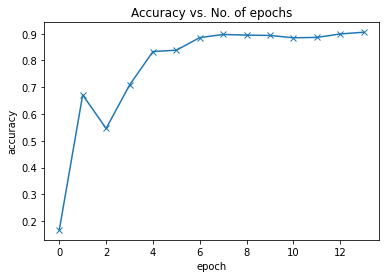

In [36]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

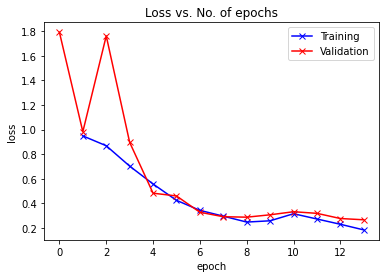

In [37]:
plot_losses(history)

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

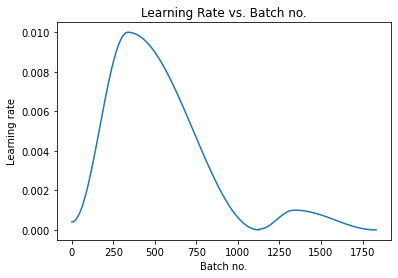

In [38]:
plot_lrs(history)

## Training Model 2 (CNN)

In [ ]:
history2 = [evaluate(model2, valid_dl)]
history2

[{'val_acc': 0.1800130158662796, 'val_loss': 1.791408896446228}]

In [ ]:
epochs2 = 5
max_lr2 = 0.01
grad_clip2 = 0.1
weight_decay2 = 1e-4
opt_func2 = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(epochs2, max_lr2, model2, train_dl, valid_dl, 
                             grad_clip=grad_clip2, 
                             weight_decay=weight_decay2, 
                             opt_func=opt_func2)

Epoch [0], last_lr: 0.00757, train_loss: 1.2989, val_loss: 1.0318, val_acc: 0.5948
Epoch [1], last_lr: 0.00950, train_loss: 1.3338, val_loss: 1.2602, val_acc: 0.4890
Epoch [2], last_lr: 0.00611, train_loss: 1.0142, val_loss: 0.9764, val_acc: 0.6032
Epoch [3], last_lr: 0.00188, train_loss: 0.8106, val_loss: 0.7480, val_acc: 0.7022
Epoch [4], last_lr: 0.00000, train_loss: 0.6658, val_loss: 0.6755, val_acc: 0.7451
CPU times: user 1min 45s, sys: 1min 43s, total: 3min 29s
Wall time: 3min 51s


In [ ]:
#Record Training Time for Model2
train_time2='0:03:51'

Let's plot the valdation set accuracies to study how the model improves over time.



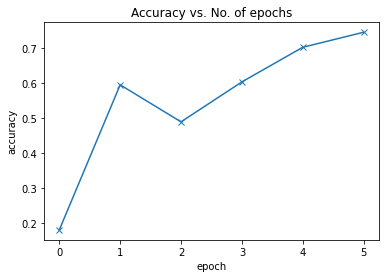

In [ ]:
plot_accuracies(history2)

We can also plot the training and validation losses to study the trend.


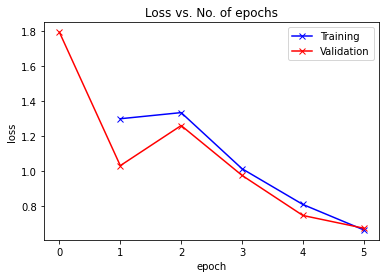

In [ ]:
plot_losses(history2)

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

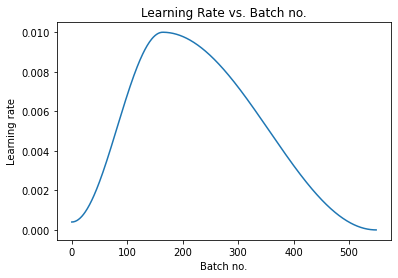

In [ ]:
plot_lrs(history2)

# Model Verification

## Testing with Individual Images

In [39]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

**Validation Image 5** 

Label: buildings
* Model 1 (Resnet9) Prediction: buildings
* Model 2 (CNN) Prediction: buildings

Label: buildings , Predicted: buildings


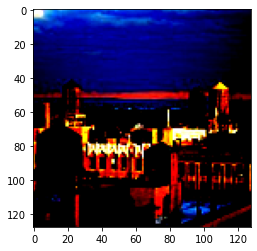

In [31]:
img, label = valid_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: buildings , Predicted: buildings


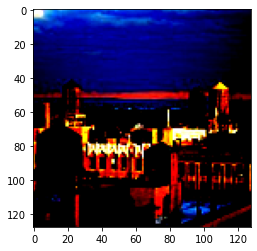

In [ ]:
img, label = valid_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

**Validation Image 500** 

Label: forest
* Model 1 (Resnet9) Prediction: forest
* Model 2 (CNN) Prediction: forest


Label: forest , Predicted: forest


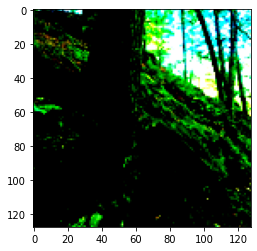

In [ ]:
img, label = valid_ds[500]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: forest , Predicted: forest


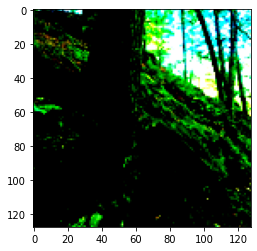

In [ ]:
img, label = valid_ds[500]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

**Validation Image 1002** 

Label: glacier

Model 1 (Resnet9) Prediction: mountain

Model 2 (CNN) Prediction: glacier

The image below does look like a mountain to me. It's probably a glacier that melted already.

Label: glacier , Predicted: mountain


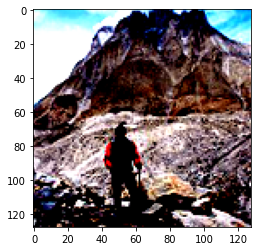

In [40]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: glacier , Predicted: glacier


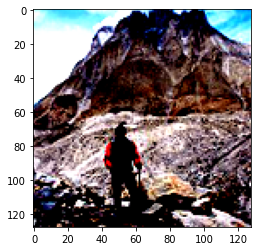

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model2))

## Save and Commit

In [41]:
!pip install jovian --upgrade --quiet

In [42]:
import jovian

### Save Model 1 paramters

In [43]:
torch.save(model.state_dict(), 'ResNet9LandscapeClassification.pth')

In [44]:
#Hyperparameters for model1
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [37]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [38]:
jovian.commit(project=project_name, environment=None, outputs=['ResNet9LandscapeClassification.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/jcawesome/landscape-classification-zerotogans-project


'https://jovian.ai/jcawesome/landscape-classification-zerotogans-project'

### Save Model 2 paramters

In [ ]:
#Hyperparameters for model2
jovian.reset()
jovian.log_hyperparams(model2_arch='CNN', 
                       model2_epochs=epochs2, 
                       model2_lr=max_lr2, 
                       model2_scheduler='one-cycle', 
                       model2_weight_decay=weight_decay2, 
                       model2_grad_clip=grad_clip2,
                       model2_opt=opt_func2.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(model2_val_loss=history2[-1]['val_loss'], 
                   model2_val_acc=history2[-1]['val_acc'],
                   model2_train_loss=history2[-1]['train_loss'],
                   model2_time=train_time2)

[jovian] Metrics logged.


In [ ]:
torch.save(model2.state_dict(), 'CnnLandscapeClassification.pth')

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['CnnLandscapeClassification.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (CnnLandscapeClassification.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/jcawesome/landscape-classification-zerotogans-project


'https://jovian.ai/jcawesome/landscape-classification-zerotogans-project'

# Summary

I am personally happy with how the model turned out. The final model (Resnet9) wsa able to predict with an accuracy of more than 90%. I'm glad to have tried at least 2 models when building this final course project.

In order to improve this notebook (using the Intel image classification dataset), I have listed down a couple of suggestions for those who want to pick up where I left of (this includes my future self):

*   Use Transfer Learning (i.e. Resnet34, VGG Imagenet)
*   Use a different batch size and tweak some of the parameters (i.e. DataLoader parameters) to improve the speed of each run
*   Try out other models (Ensemble Neural Networks)
* Figure out how to run multiple models and load them into the same GPU. Currently encountering this error after running one of the models. Current solution is to restart runtime
> RuntimeError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 14.73 GiB total capacity; 9.82 GiB already allocated; 1.05 GiB free; 12.74 GiB reserved in total by PyTorch)




## Final Words on **"Deep Learning with PyTorch: Zero to GANs"**

I have always enjoyed numbers and findings patterns. When I heard about the data science career and its potential, I was hooked. However, I have put off learning to become a data scientist for the longest time. I only watch videos online and didn't have enough time (or motivation to devote time) to learn by doing (actually coding). This Zero to Gans course in Jovian by Aakash N S has truly been a wonderful experience that is full of learning about what's new in the field of deep learning and machine learning. This is truly a big step for me to complete this course project. I hope to become a better data scientist in the coming years of my career. I would like to reach out to the Jovian team. Splendid job in creating the course materials. I look forward to attend more courses from jovian.

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/jcawesome/landscape-classification-zerotogans-project


'https://jovian.ai/jcawesome/landscape-classification-zerotogans-project'